In [384]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

import warnings

### 1.DISPLAY SETTINGS 

In [3]:
pd.set_option("display.max_columns",None)

In [5]:
sklearn.set_config(transform_output="pandas")

In [7]:
warnings.filterwarnings("ignore")

### 2.ACCESSING THE DATA FROM DATABASE.

In [9]:
from sqlalchemy import create_engine
from sqlalchemy.engine import URL

In [11]:
import psycopg2
hostname = 'localhost'
database = 'nyfd'
user_name ='postgres'
pwd ='raksha'
port_id = 5432
conn =None
cur =None

In [13]:
engine = create_engine(f'postgresql://{user_name}:{pwd}@{hostname}:{port_id}/{database}')

In [15]:
sql = 'SELECT * FROM f_eng_col'

In [17]:
f_eng = pd.read_sql_query(sql,engine)

In [19]:
f_eng.sample(5)

,facility,date_of_inspection_transformed,violation_item,critical_violation,total_critical_violations,total_crit_not_corrected,total_noncritical_violations,local_health_department,permit_expiration_date,food_service_type,inspection_type
387417,DUNKIN DONUTS/BASKIN ROBBINS,2010-07-04,12A,Not Critical Violation,0.0,0.0,3.0,Nassau County,1970-01-21 04:16:19.200,Food Service Establishment,Inspection
1108501,FU WAI KITCHEN,2024-07-03,15B,Not Critical Violation,5.0,0.0,24.0,Nassau County,1970-01-21 02:06:43.200,Food Service Establishment,Inspection
257489,PINE BUSH CHINESE RESTAURANT,2020-12-18,15B,Not Critical Violation,0.0,0.0,6.0,Orange County,1970-01-21 03:31:40.800,Food Service Establishment,Re-Inspection
775352,BAGEL WORLD OF ORANGE COUNTY,2024-03-25,12E,Not Critical Violation,0.0,0.0,1.0,Orange County,1970-01-21 04:16:19.200,Food Service Establishment,Inspection
191880,BITTERS & BONES,2018-10-23,8A,Not Critical Violation,3.0,0.0,10.0,Saranac Lake District Office,1970-01-20 23:11:02.400,Food Service Establishment,Inspection


In [21]:
f_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310734 entries, 0 to 1310733
Data columns (total 11 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   facility                        1310734 non-null  object        
 1   date_of_inspection_transformed  1310734 non-null  datetime64[ns]
 2   violation_item                  1310734 non-null  object        
 3   critical_violation              1310734 non-null  object        
 4   total_critical_violations       1310734 non-null  float64       
 5   total_crit_not_corrected        1310734 non-null  float64       
 6   total_noncritical_violations    1310734 non-null  float64       
 7   local_health_department         1310734 non-null  object        
 8   permit_expiration_date          1310734 non-null  datetime64[ns]
 9   food_service_type               1310734 non-null  object        
 10  inspection_type                 1310734 no

In [23]:
#creating a  function to not make any changes in original dataset
def feature_eng(data):
    return data.copy()


In [25]:
ff_eng = feature_eng(f_eng)

## 3.1 facility

In [27]:
ff_eng['facility'] = ff_eng.facility.str.upper()

In [29]:
ff_eng.facility.sample(5)

235101                        BLUE RIBBON DINER
61416                         NEW WAN BO BUFFET
878885          YONKERS B.O.E. - CESAR & CHAVEZ
613401                            CLARION HOTEL
1136136    CHARTWELLS DINING SERVICE - MAIN DIN
Name: facility, dtype: object

In [31]:
lowercase_present = ff_eng['facility'].str.contains('[a-z]').any()

print(lowercase_present)

False


In [33]:
lowercase_present = f_eng['facility'].str.contains('[a-z]').any()

print(lowercase_present)

True


- Dividing the `facility` into `categories`

In [49]:
import pandas as pd
from fuzzywuzzy import process, fuzz

# Define categories and keywords with expanded lists
categories = {
    'Fast Food': [
        'MCDONALDS', 'BURGER KING', 'TACO BELL', 'KFC', 'SUBWAY', 'DOMINOS', 
        'PIZZA HUT', 'POPEYES', 'CHICK-FIL-A', 'ARBY\'S', 'SONIC', 'DUNKIN', 
        'SHAKE SHACK', 'IN-N-OUT', 'FIVE GUYS', 'JACK IN THE BOX', 'FAST', 'FOOD', 
        'WENDYS', 'PIZZERIA', 'BURGER', 'SUBWAY', 'WOK', 'KING', 'CHICKEN'
    ],
    'Indian': [
        'INDIA', 'CURRY', 'MASALA', 'TANDOOR', 'BIRYANI', 'DAL', 'PANEER', 
        'CHAAT', 'DHABA', 'MUGHLAI', 'TIKKA', 'NAAN', 'DOSAS', 'SAMOSA', 
        'CHAAT HOUSE', 'TANDOORI', 'BOLLYWOOD', 'KABAB', 'BANGALORE', 'INDIAN', 
        'MAHAL'
    ],
    'Chinese': [
        'CHINA', 'DRAGON', 'WOK', 'DIM SUM', 'SZECHUAN', 'MANDARIN', 'PEKING', 
        'CHOPSTICK', 'HOT POT', 'HUNAN', 'GOLDEN', 'GARDEN', 'BAMBOO', 
        'LOTUS', 'PANDA', 'JADE', 'FORTUNE', 'DYNASTY', 'CHINESE', 'SHANGHAI'
    ],
    'Italian': [
        'PIZZA', 'PASTA', 'ITALIAN', 'RISTORANTE', 'TRATTORIA', 'OSTERIA', 
        'GELATO', 'PIZZERIA', 'SPAGHETTI', 'ALFREDO', 'CARBONARA', 'MARGHERITA', 
        'LASAGNA', 'BOLOGNESE', 'MAMMA', 'NAPOLI', 'ROMA', 'VENETIAN', 'ITALY'
    ],
    'Japanese': [
        'SUSHI', 'JAPAN', 'RAMEN', 'TERIYAKI', 'TEMPURA', 'UDON', 'KATSU', 
        'SASHIMI', 'TEPPANYAKI', 'IZAKAYA', 'SHABU-SHABU', 'YAKITORI', 
        'DONBURI', 'KAISEN', 'TONKATSU', 'MISO', 'KIMONO', 'KYOTO', 'JAPANESE'
    ],
    'Mexican': [
        'TACO', 'BURRITO', 'MEXICO', 'QUESADILLA', 'ENCHILADA', 'FAJITA', 
        'SALSA', 'GUACAMOLE', 'TEQUILA', 'CANTINA', 'BODEGA', 'TAQUERIA', 
        'HUEVOS', 'CHORIZO', 'MOLE', 'TAMALE', 'JALAPENO', 'TORTA', 'MEXICAN'
    ],
    'American': [
        'DINER', 'GRILL', 'BBQ', 'STEAKHOUSE', 'CAFÉ', 'BREWERY', 'PUB', 
        'BAR', 'BURGER', 'AMERICAN', 'ROADSIDE', 'ROUTE', 'SMOKEHOUSE', 
        'ROASTERY', 'TAVERN', 'HOUSE', 'BAR & GRILL', 'CHOPHOUSE', 'DELTA', 
        'STATE', 'WESTERN', 'AMERICAN', 'DELI', 'BURGER', 'GRILL', 'STEAKHOUSE', 'HOUSE'
    ],
    'Other': []
}

# Flatten the keyword list for fuzzy matching
all_keywords = [keyword for keywords in categories.values() for keyword in keywords]

# Function to categorize restaurant names with fuzzy matching
def categorize_restaurant_fuzzy(name):
    name = name.upper()
    best_match, score = process.extractOne(name, all_keywords, scorer=fuzz.partial_ratio)
    if score >= 80:  # Adjust the threshold as needed
        for category, keywords in categories.items():
            if best_match in keywords:
                return category
    return 'Other'

# Clean the data by converting all non-string values to empty strings
ff_eng['facility'] = ff_eng['facility'].fillna('').astype(str)

# Apply the fuzzy categorization function
ff_eng['restaurant_category'] = ff_eng['facility'].apply(categorize_restaurant_fuzzy)



In [51]:
ff_eng.restaurant_category.value_counts()

restaurant_category
Other        667286
American     247566
Fast Food    168518
Italian       82254
Chinese       62948
Mexican       30189
Indian        27932
Japanese      24041
Name: count, dtype: int64

In [216]:
rest_cat_pipe = Pipeline(
    steps=[
        ("ohe",OneHotEncoder(handle_unknown='ignore',sparse_output=False))
    ]
)
rest_cat_pipe.fit_transform(ff_eng[["restaurant_category"]])

,restaurant_category_American,restaurant_category_Chinese,restaurant_category_Fast Food,restaurant_category_Indian,restaurant_category_Italian,restaurant_category_Japanese,restaurant_category_Mexican,restaurant_category_Other
485994,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
791441,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
625,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5684,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
171324,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
468718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
779662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1091655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1255155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 3.2 date of inspection 

- Creating new feature `days since last inspection`using date_of_inspection.

In [95]:
ff_eng = ff_eng.sort_values(['facility','date_of_inspection_transformed'])
ff_eng['days_since_last_inspection'] = ff_eng.groupby('facility')['date_of_inspection_transformed'].transform(lambda x: x.diff().dt.days.fillna(0))

In [97]:
ff_eng.days_since_last_inspection.value_counts()

days_since_last_inspection
0.0       812308
1.0         3632
364.0       3396
7.0         3307
365.0       2984
           ...  
2182.0         1
1648.0         1
3648.0         1
1789.0         1
2597.0         1
Name: count, Length: 2449, dtype: int64

- so, they are so many `unique days category` to decrease category count, lets make into ` intervals`

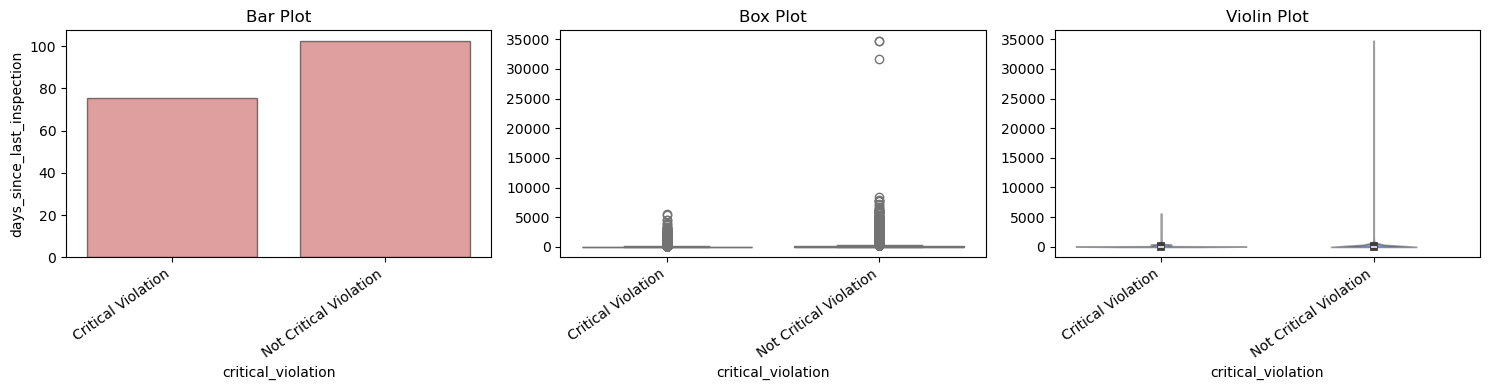

In [117]:
eda_helper_functions.num_cat_bivar_plots(ff_eng,"days_since_last_inspection","critical_violation")

In [220]:
days_since_pipe = Pipeline(
    steps=[
        ('scaler',StandardScaler())
    ]
)
days_since_pipe.fit_transform(ff_eng[['days_since_last_inspection']])

,days_since_last_inspection
485994,-0.493954
791441,0.112744
625,0.222149
5684,1.465383
171324,-0.319901
...,...
468718,-0.493954
779662,-0.493954
1091655,-0.493954
1255155,-0.493954


## 3.3 Violation item

In [138]:
#unique violation codes list
vi = [item for item in ff_eng.violation_item.unique()]
vi_df = pd.DataFrame(vi)
vi_df.to_excel('item.xlsx',index=False)

In [144]:
# Defining categories
categories = {
    'Food Temperature and Storage': [
        '8D', '12D', '11B', '8A', '8B', '15A', '15B', '10A', '8E', '8C', '8G', 
        '8F', '8', '12', '10', '2A', '2B', '2C', '2D', '2E', '3A', '3B', '3C'
    ],
    'Sanitation and Hygiene': [
        '12E', '5A', '15A', '5E', '11D', '11C', '14A', '11A', '14B', '1H', '1D', 
        '5C', '5B', '5D', '1B', '9D', '1E', '1G', '1A', '1C', '9B', '9A', '4A', '1'
    ],
    'Equipment and Facility Maintenance': [
        '16', '3C', '7F', '13A', '13B', '12A', '6A', '9C', '4D', '4C', '4B', 
        '3B', '3A', '7A', '7H', '7C', '7B', '7D', '7E', '2D', '5A', '5B', '5C', '5D', '5E',
        '8A', '8B', '8C', '8D', '8E', '8F', '8G'
    ],
    'Safety and Compliance': [
        '4A', '4B', '4C', '4D', '11A', '11B', '11C', '11D', '12A', '12B', '12C', '12D', '12E', 
        '6A', '6B', '7A', '7B', '7C', '7D', '7E', '7F', '7G', '7H', '10A', '10B', '13A', '13B', 
        '14A', '14B', '14C', '15A', '15B', '15C', '15D', '16', '17'
    ],
    'Uncategorized': [
        'Nan', '15', '29', '19', '11', '14', '24', '25', '10', '2', '26', '18', '33', '1', '13', 
        '20', '22', '62', '21', '47', '41', '28', '46', '30', '23', '35', '6', '9', '12', '8', '4'
    ]
}

# Function to categorize the violation codes
def categorize_violations(codes, categories):
    categorized = {category: [] for category in categories}
    for code in codes:
        found = False
        for category, cat_codes in categories.items():
            if code in cat_codes:
                categorized[category].append(code)
                found = True
                break
        if not found:
            categorized.setdefault('Uncategorized', []).append(code)
    return categorized

# Categorizing the violation codes
categorized_violations = categorize_violations(vi, categories)

# Print the categorized violations
for category, codes in categorized_violations.items():
    print(f"{category}: {codes}")



Food Temperature and Storage: ['8D', '12D', '11B', '8A', '8B', '15A', '15B', '10A', '8E', '2C', '2E', '8C', '3C', '8F', '2A', '2B', '3B', '8G', '3A', '2D', '10', '12', '8']
Sanitation and Hygiene: ['12E', '5A', '11D', '5E', '11C', '14A', '11A', '14B', '1H', '1D', '5C', '4A', '5B', '1B', '1G', '1A', '1C', '9B', '5D', '1E', '9D', '9A', '1']
Equipment and Facility Maintenance: ['6A', '7F', '9C', '13A', '16', '13B', '12A', '4D', '4C', '4B', '7E', '7A', '7H', '7C', '7B', '7D']
Safety and Compliance: ['12C', '10B', '14C', '15C', '6B', '12B', '15D', '7G', '17']
Uncategorized: ['Nan', '1F', '15', '29', '19', '11', '14', '24', '25', '2', '26', '18', '33', '13', '20', '22', '62', '21', '47', '41', '28', '46', '30', '23', '35', '6', '9', '4']


In [146]:
def categorize_violation(item):
    for category, codes in categories.items():
        if item in codes:
            return category
    return 'Uncategorized'

ff_eng['violation_cat'] = ff_eng['violation_item'].apply(categorize_violation)

In [150]:
ff_eng.violation_cat.value_counts()

violation_cat
Food Temperature and Storage          501324
Sanitation and Hygiene                350550
Uncategorized                         242667
Safety and Compliance                 143129
Equipment and Facility Maintenance     73064
Name: count, dtype: int64

In [154]:
eda_helper_functions.cat_summary(ff_eng, "violation_cat")

485994                    Uncategorized
791441                    Uncategorized
625                       Uncategorized
5684                      Uncategorized
171324                    Uncategorized
                       ...             
468718           Sanitation and Hygiene
779662     Food Temperature and Storage
1091655          Sanitation and Hygiene
1255155    Food Temperature and Storage
1262668          Sanitation and Hygiene
Name: violation_cat, Length: 1310734, dtype: object

Data Type      : object
Cardinality    : 5 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 1,310,734 / 1,310,734 rows


,
count,1310734
unique,5
top,Food Temperature and Storage
freq,501324


,count,percentage
category,,
Food Temperature and Storage,501324,0.382476
Sanitation and Hygiene,350550,0.267446
Uncategorized,242667,0.185138
Safety and Compliance,143129,0.109198
Equipment and Facility Maintenance,73064,0.055743


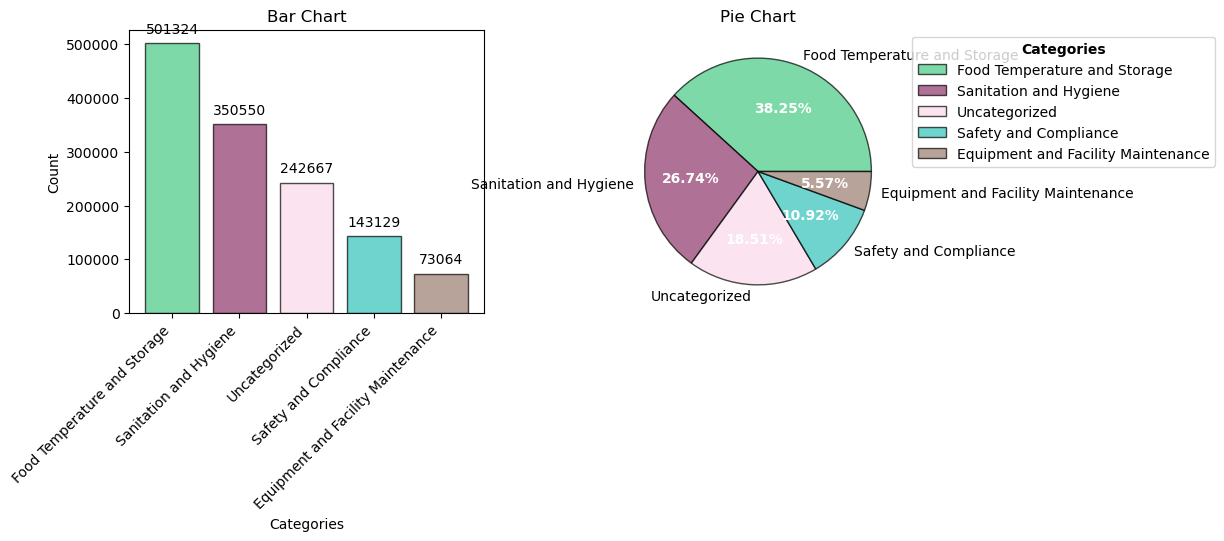

In [156]:
eda_helper_functions.cat_univar_plots(ff_eng, "violation_cat", show_wordcloud=False)


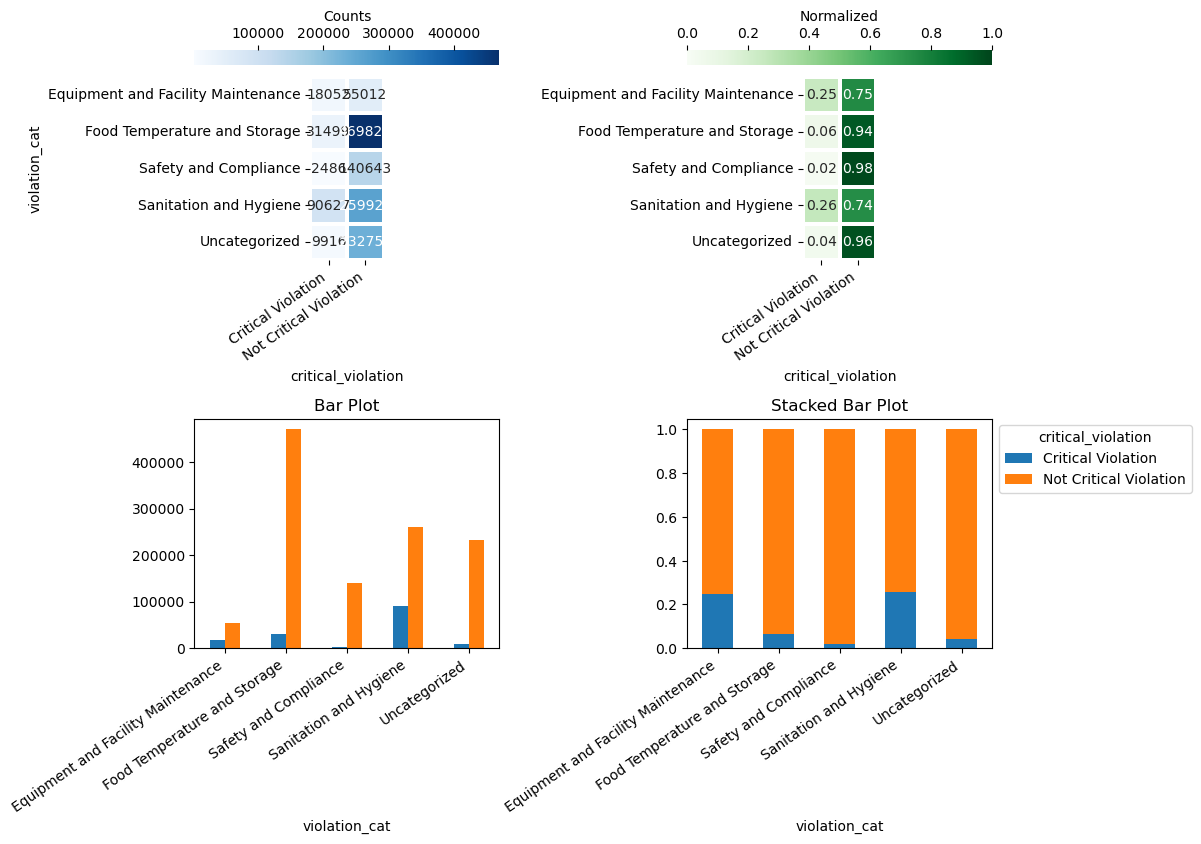

In [162]:
eda_helper_functions.cat_bivar_plots(ff_eng,"violation_cat","critical_violation")

In [164]:
eda_helper_functions.hyp_cat_cat(ff_eng,"violation_cat","critical_violation")


- Cramers V            : 0.3051680200330418
- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 122069.31426613315
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables violation_cat and critical_violation are correlated


In [224]:
violation_code_pipe = Pipeline(
    steps=[
        ('ohe',OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
)
violation_code_pipe.fit_transform(ff_eng[['violation_cat']])

,violation_cat_Equipment and Facility Maintenance,violation_cat_Food Temperature and Storage,violation_cat_Safety and Compliance,violation_cat_Sanitation and Hygiene,violation_cat_Uncategorized
485994,0.0,0.0,0.0,0.0,1.0
791441,0.0,0.0,0.0,0.0,1.0
625,0.0,0.0,0.0,0.0,1.0
5684,0.0,0.0,0.0,0.0,1.0
171324,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
468718,0.0,0.0,0.0,1.0,0.0
779662,0.0,1.0,0.0,0.0,0.0
1091655,0.0,0.0,0.0,1.0,0.0
1255155,0.0,1.0,0.0,0.0,0.0


## 3.4 local health department

In [173]:
eda_helper_functions.hyp_cat_cat(ff_eng,"local_health_department","critical_violation")


- Cramers V            : 0.10118027920029052
- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 13462.562141358048
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables local_health_department and critical_violation are correlated


## 3.4 Permit expiration date

In [196]:
permit_date_pipeline = Pipeline(
    steps=[
        ('permitdt',DatetimeFeatures(features_to_extract=['month','year'])),
        ('scaler',MinMaxScaler())
    ]
)
permit_date_pipeline.fit_transform(ff_eng.loc[:, ["permit_expiration_date"]])

,permit_expiration_date_month,permit_expiration_date_year
485994,0.0,1.0
791441,0.0,1.0
625,0.0,1.0
5684,0.0,1.0
171324,0.0,1.0
...,...,...
468718,0.0,1.0
779662,0.0,1.0
1091655,0.0,1.0
1255155,0.0,1.0


## 3.5 ALL CRITICAL VIOLATIONS

In [234]:
vio_info_cols=ff_eng[['total_critical_violations',
       'total_crit_not_corrected', 'total_noncritical_violations']]


In [236]:
vio_crit_pipe = Pipeline(
    steps=[
        ('scaler',StandardScaler())
    ]
)
vio_crit_pipe.fit_transform(vio_info_cols)

,total_critical_violations,total_crit_not_corrected,total_noncritical_violations
485994,-0.000023,-0.000004,-0.000020
791441,-0.000023,-0.000004,-0.000020
625,-0.000023,-0.000004,-0.000020
5684,3.009516,-0.100723,-1.050295
171324,-0.000023,-0.000004,-0.000020
...,...,...,...
468718,-0.584196,-0.100723,0.749872
779662,-0.584196,-0.100723,0.749872
1091655,-0.584196,-0.100723,0.749872
1255155,-0.584196,-0.100723,0.749872


## 3.6 food service type and inspection type

In [243]:
ff_eng.food_service_type.value_counts()

food_service_type
Food Service Establishment    1131786
Institutional Food Service     154691
SED Summer Feeding Prog.        14210
SOFA Food Service               10047
Name: count, dtype: int64

In [299]:
food_service_pipe = Pipeline(
    steps=[
        ('ohe',OneHotEncoder(handle_unknown='ignore',sparse_output=False))
    ]
)
food_service_pipe.fit_transform(ff_eng[['food_service_type']])

,food_service_type_Food Service Establishment,food_service_type_Institutional Food Service,food_service_type_SED Summer Feeding Prog.,food_service_type_SOFA Food Service
485994,1.0,0.0,0.0,0.0
791441,1.0,0.0,0.0,0.0
625,1.0,0.0,0.0,0.0
5684,1.0,0.0,0.0,0.0
171324,1.0,0.0,0.0,0.0
...,...,...,...,...
468718,1.0,0.0,0.0,0.0
779662,1.0,0.0,0.0,0.0
1091655,1.0,0.0,0.0,0.0
1255155,1.0,0.0,0.0,0.0


In [301]:
insp_type_pipe = Pipeline(
    steps=[
        ('ohe',OneHotEncoder(handle_unknown='ignore',sparse_output=False))
    ]
)
insp_type_pipe.fit_transform(ff_eng[['inspection_type']])

,inspection_type_Inspection,inspection_type_Re-Inspection
485994,1.0,0.0
791441,0.0,1.0
625,0.0,1.0
5684,1.0,0.0
171324,0.0,1.0
...,...,...
468718,1.0,0.0
779662,1.0,0.0
1091655,1.0,0.0
1255155,1.0,0.0


In [339]:
X = ff_eng.drop(columns=['critical_violation'])
y= ff_eng['critical_violation']

In [361]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


## Column transformer

In [363]:
column_transformer = ColumnTransformer(
    transformers=[
        ('rest_cat',rest_cat_pipe,['restaurant_category']),
        ('days_since_ins',days_since_pipe,['days_since_last_inspection']),
        ('vio_cat',violation_code_pipe,['violation_cat']),
        ('allvio', vio_crit_pipe, ['total_critical_violations', 'total_crit_not_corrected', 'total_noncritical_violations']),
        ('permit',permit_date_pipeline,['permit_expiration_date']),
        ('servtyp',food_service_pipe ,['food_service_type']),
        ('insptyp',insp_type_pipe,['inspection_type']),
        
    ], remainder="passthrough"
)
column_transformer.fit_transform(X,y_encoded)

,rest_cat__restaurant_category_American,rest_cat__restaurant_category_Chinese,rest_cat__restaurant_category_Fast Food,rest_cat__restaurant_category_Indian,rest_cat__restaurant_category_Italian,rest_cat__restaurant_category_Japanese,rest_cat__restaurant_category_Mexican,rest_cat__restaurant_category_Other,days_since_ins__days_since_last_inspection,vio_cat__violation_cat_Equipment and Facility Maintenance,vio_cat__violation_cat_Food Temperature and Storage,vio_cat__violation_cat_Safety and Compliance,vio_cat__violation_cat_Sanitation and Hygiene,vio_cat__violation_cat_Uncategorized,allvio__total_critical_violations,allvio__total_crit_not_corrected,allvio__total_noncritical_violations,permit__permit_expiration_date_month,permit__permit_expiration_date_year,servtyp__food_service_type_Food Service Establishment,servtyp__food_service_type_Institutional Food Service,servtyp__food_service_type_SED Summer Feeding Prog.,servtyp__food_service_type_SOFA Food Service,insptyp__inspection_type_Inspection,insptyp__inspection_type_Re-Inspection,remainder__facility,remainder__date_of_inspection_transformed,remainder__violation_item,remainder__local_health_department,remainder__inspection_interval_category
485994,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.493954,0.0,0.0,0.0,0.0,1.0,-0.000023,-0.000004,-0.000020,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,"#1 KING'S BUFFET, A",2000-03-08,Nan,Canton District Office,0-30 days
791441,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.112744,0.0,0.0,0.0,0.0,1.0,-0.000023,-0.000004,-0.000020,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,"#1 KING'S BUFFET, A",2000-07-08,Nan,Canton District Office,121-240 days
625,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.222149,0.0,0.0,0.0,0.0,1.0,-0.000023,-0.000004,-0.000020,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,"#1 KING'S BUFFET, A",2000-11-29,Nan,Canton District Office,121-240 days
5684,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.465383,0.0,0.0,0.0,0.0,1.0,3.009516,-0.100723,-1.050295,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,"#1 KING'S BUFFET, A",2001-12-28,Nan,Canton District Office,365+ days
171324,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.319901,0.0,0.0,0.0,0.0,1.0,-0.000023,-0.000004,-0.000020,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,"#1 KING'S BUFFET, A",2002-02-01,Nan,Canton District Office,31-60 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.493954,0.0,0.0,0.0,1.0,0.0,-0.584196,-0.100723,0.749872,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,ZUPPA,2024-02-01,11C,Westchester County,0-30 days
779662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.493954,0.0,1.0,0.0,0.0,0.0,-0.584196,-0.100723,0.749872,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,ZUPPA,2024-02-01,8A,Westchester County,0-30 days
1091655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.493954,0.0,0.0,0.0,1.0,0.0,-0.584196,-0.100723,0.749872,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,ZUPPA,2024-02-01,11D,Westchester County,0-30 days
1255155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.493954,0.0,1.0,0.0,0.0,0.0,-0.584196,-0.100723,0.749872,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,ZUPPA,2024-02-01,10A,Westchester County,0-30 days


## Feature selection

In [396]:
estimator = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="f1",
	threshold=0.1
) 

## PREPROCRESSING

In [406]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

fe = preprocessor.fit_transform(X,y_encoded)

## Visualization

In [400]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'rest_cat__restaurant_category_American': 0.9381988976412862,
 'rest_cat__restaurant_category_Chinese': 0.9381988976412862,
 'rest_cat__restaurant_category_Fast Food': 0.9381988976412862,
 'rest_cat__restaurant_category_Indian': 0.9381988976412862,
 'rest_cat__restaurant_category_Italian': 0.9381988976412862,
 'rest_cat__restaurant_category_Japanese': 0.9381988976412862,
 'rest_cat__restaurant_category_Mexican': 0.9381988976412862,
 'rest_cat__restaurant_category_Other': 0.9381988976412862,
 'days_since_ins__days_since_last_inspection': 0.9381988976412862,
 'vio_cat__violation_cat_Equipment and Facility Maintenance': 0.9381988976412862,
 'vio_cat__violation_cat_Food Temperature and Storage': 0.9381988976412862,
 'vio_cat__violation_cat_Safety and Compliance': 0.9381988976412862,
 'vio_cat__violation_cat_Sanitation and Hygiene': 0.9381988976412862,
 'vio_cat__violation_cat_Uncategorized': 0.9381988976412862,
 'allvio__total_critical_violations': 0.9381988976412862,
 'allvio__total_crit

In [402]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'rest_cat__restaurant_category_American': 0.9381988976412862,
 'rest_cat__restaurant_category_Chinese': 0.9381988976412862,
 'rest_cat__restaurant_category_Fast Food': 0.9381988976412862,
 'rest_cat__restaurant_category_Indian': 0.9381988976412862,
 'rest_cat__restaurant_category_Italian': 0.9381988976412862,
 'rest_cat__restaurant_category_Japanese': 0.9381988976412862,
 'rest_cat__restaurant_category_Mexican': 0.9381988976412862,
 'rest_cat__restaurant_category_Other': 0.9381988976412862,
 'days_since_ins__days_since_last_inspection': 0.9381988976412862,
 'vio_cat__violation_cat_Equipment and Facility Maintenance': 0.9381988976412862,
 'vio_cat__violation_cat_Food Temperature and Storage': 0.9381988976412862,
 'vio_cat__violation_cat_Safety and Compliance': 0.9381988976412862,
 'vio_cat__violation_cat_Sanitation and Hygiene': 0.9381988976412862,
 'vio_cat__violation_cat_Uncategorized': 0.9381988976412862,
 'allvio__total_critical_violations': 0.9381988976412862,
 'allvio__total_crit

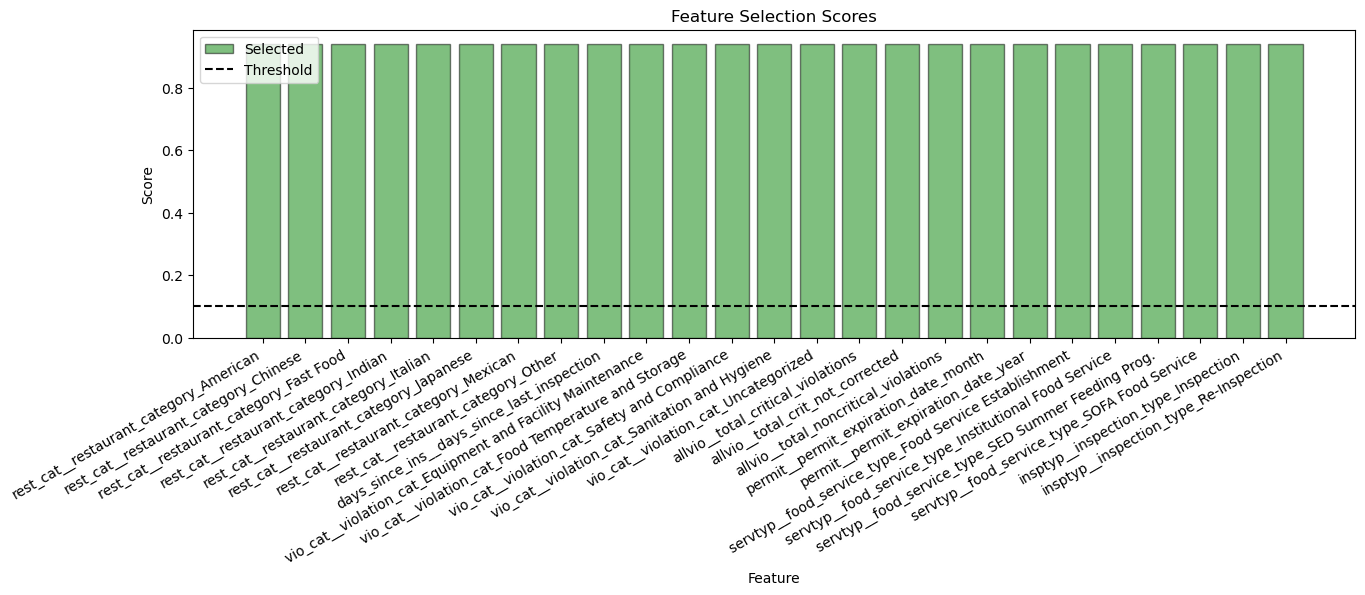

In [404]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

## UPLOADING NEW DATASET INTO DATABASE

In [418]:
fe.to_sql('new_features',engine,if_exists='replace',index=False)

734